# Feature Engineering Notebook

This notebook takes the reconfigured files from the first notebook and explores the data.  We create new features and get the data in the proper format for analysis.  

In [350]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
import datatools

%matplotlib inline

In [351]:
#Bring in the data

nba = pd.read_csv('./data/nba_combined.csv')
nba.dropna(inplace = True)

In [352]:
#bring in test data 
nba_test = pd.read_csv('./data/nba_test.csv')

## Look at the Data

Let us look at the Distribution of the win margins that we will try and predict as well as how well the line does in separating the data.

To do this we want to look at the distribution of final scores.  We look at the average home win Margin of NBA teams.  We can see that the home team wins by an average of 3.1 point with a standard deviation of 13.  We can assume with this data that the average home court advantage would add 3.1 points to the home team scores.


In [353]:
print('The standard deviation of the Win Margins is ',np.std(nba.home_win_margin))
print('The mean home winning margin is ', nba.home_win_margin.mean())

The standard deviation of the Win Margins is  13.362387181118889
The mean home winning margin is  3.02041992589543


In [354]:
graph = datatools.DataGrapher()

Let Graph


In [355]:
graph.getdata(nba)

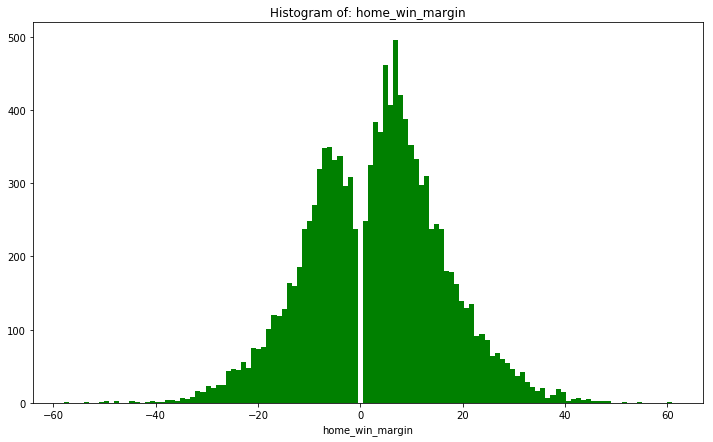

In [356]:
graph.plothist('home_win_margin', bins = 120)


We also want to look at the value of the points throughout the dataset. As line shopping can be an important factor in final win percentage.  We see that the home team winning by 7 is the most common occurrence landing about 4 percent of the time.  Line shopping can drastically change one's winning percentage. 

In [357]:
nba.home_win_margin.value_counts(normalize= True)

 7.0     0.040758
 5.0     0.037958
 8.0     0.034582
 6.0     0.033512
 9.0     0.031947
 3.0     0.031618
 4.0     0.030465
 10.0    0.028983
-6.0     0.028818
-7.0     0.028654
-4.0     0.027748
 11.0    0.027419
-5.0     0.027336
 2.0     0.026760
-8.0     0.026266
 13.0    0.025525
-2.0     0.025360
 12.0    0.024455
-3.0     0.024372
-9.0     0.022231
-10.0    0.020502
 1.0     0.020420
 15.0    0.020091
-1.0     0.019597
-11.0    0.019514
 14.0    0.019514
 16.0    0.019514
-12.0    0.015233
 17.0    0.014821
 18.0    0.014739
           ...   
-33.0    0.000659
-35.0    0.000576
 43.0    0.000576
 37.0    0.000576
 45.0    0.000494
 42.0    0.000494
-34.0    0.000494
-38.0    0.000329
-37.0    0.000329
 44.0    0.000329
-41.0    0.000247
 49.0    0.000247
-50.0    0.000165
 41.0    0.000165
-45.0    0.000165
-48.0    0.000165
-36.0    0.000165
 46.0    0.000165
 48.0    0.000165
 47.0    0.000165
-51.0    0.000082
-40.0    0.000082
-39.0    0.000082
-54.0    0.000082
 61.0    0

### Difference Between Actual Result and the Line

Line_cv is the home winning margin plus the line.  It is an indication of how far off the line  makers are from the actual result.  With a mean of -.2 The bookmakers have a very slight bias for the home team.  This is expected as the average better generally likes to bet favorites which most often are the home team. The bias is not big enough to make betting away team profitable.

In [358]:
print('The standard deviation of bookmaker errors ',np.std(nba.line_cv))
print('The mean of bookmaker errors', nba.line_cv.mean())

The standard deviation of bookmaker errors  11.910180196165754
The mean of bookmaker errors -0.1688719637710992


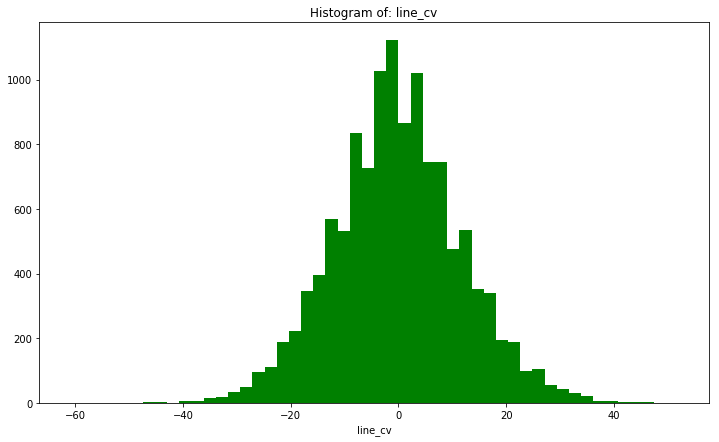

In [359]:
graph.plothist('line_cv')

The Error from the line is pretty normally distributed around zero.  With a mean of -.2 and standard deviation of 11.  The standard deviation is high but that is to be expected.  Anyone that has ever watch an NBA game knows that there is large variance at the end of games with teams fouling and shooting with irregularity based on no real reason other than that games characteristics

### Covers

Here we look at the actual variable of interest did a team cover the spread or not.  It is complicated by the inclusion of pushes.  If the game lands on the number neither the bettor or the house wins.  This occurs in about 2% of cases.  However, it complicates the analysis as we group the ties in with the null class. We do create a new payout variable that we will use to measure success that does take into account the ties. 

In [360]:
nba.cover.value_counts()

0    6310
1    5835
Name: cover, dtype: int64

In [361]:
nba.cover.value_counts(normalize = True)

0    0.519555
1    0.480445
Name: cover, dtype: float64

In [362]:
nba.away_cover.value_counts(normalize = True)

0    0.5007
1    0.4993
Name: away_cover, dtype: float64

When we look at the away covers we can see the number of pushes is just under 2%. Currently pushes are considered losses but the values need to be recalibrated to 0 since a push is equivalent to a no bet.

The actual ratio of away to home covers would be 

         .48 / .48 + 50 = 49% 
    
Leaving 51% of away teams to cover since we need 52.38% to cover it away games might provide us with more value

### Calulate returns to account for pushes

In reality this is a multinomial categorization problem as there is a push class.  It is roughly 2% of the data.  However, I am uninterested in the push class.  However, I calculate the payout since I am combining it with the negative class. I can get a better idea of the payout by subtracting out the pushes at the end of the analysis

In [363]:
# add training payouts of .909, -1 and 0 respectively
conditions = [
    (nba['line_cv'] <0), 
    (nba['line_cv'] > 0),
    (nba['line_cv'] == 0)]
choices = [.909, -1, 0]
nba['away_payout'] = np.select(conditions, choices)

In [364]:
print(nba.away_payout.value_counts())


 0.909    6064
-1.000    5835
 0.000     246
Name: away_payout, dtype: int64


In [365]:
conditions = [
    (nba['line_cv'] >0), 
    (nba['line_cv'] < 0),
    (nba['line_cv'] == 0)]
choices = [.909, -1, 0]
nba['home_payout'] = np.select(conditions, choices)

In [366]:
print(nba.home_payout.value_counts())


-1.000    6064
 0.909    5835
 0.000     246
Name: home_payout, dtype: int64


Value count numbers match up nicely

### Look at Correlation Heat Map

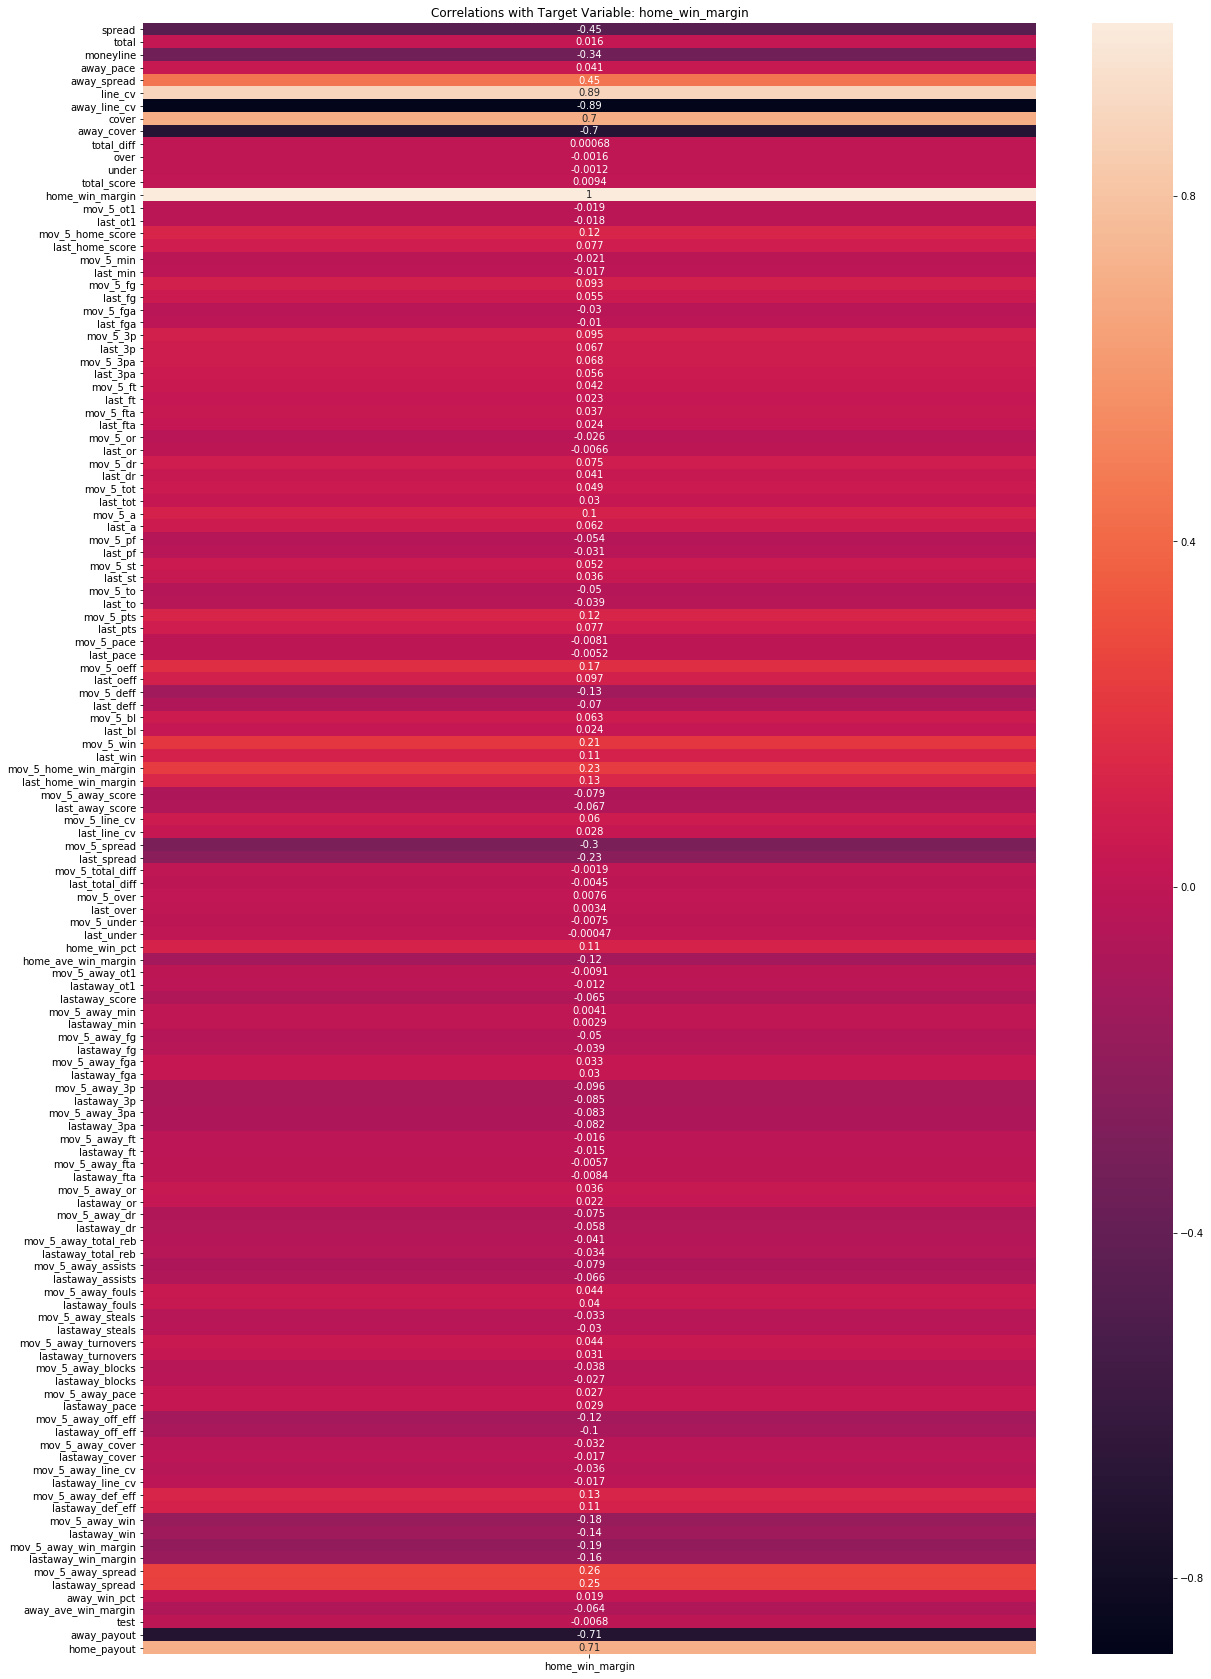

In [367]:
graph.plotheatc('home_win_margin')

Most of the correlations are small and 

#### Spread 

One would expect the spread to be a predictor of home win margin as it is the line the books put out to divide the action.  The spread should move with the actual win margin.

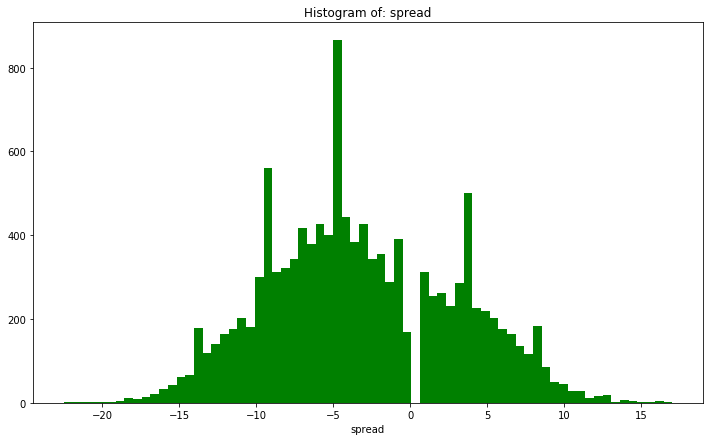

In [368]:
graph.plothist('spread', bins = 70)

In [369]:
print('The standard deviation of spread ',np.std(nba.spread))
print('The mean of spread', nba.spread.mean())

The standard deviation of spread  6.1503234369241016
The mean of spread -3.189291889666529


You will notice here that the mean spread is -3.27 and the standard deviation is 6.1.  Compare that to the home win margin information. 
The home_win_margin had a mean of 3.03 almost the inverse of the spread but a larger standard deviation of 13.  This shows us that the spread is centered on the average win value but does not move as much.  They err towards the center. Suggesting that the spread is calculated by using a formula that compiles many results to cut down on variance.

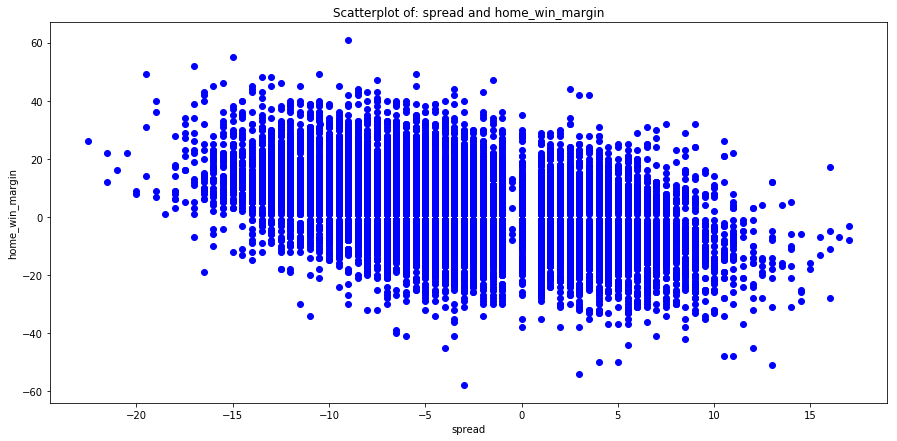

In [370]:
graph.plotscat('spread', 'home_win_margin')

In [371]:
nba.home_win_margin.corr(nba.spread)
#strong negative correlation as expected since line is opposite of win
#margin

-0.4534239105587527

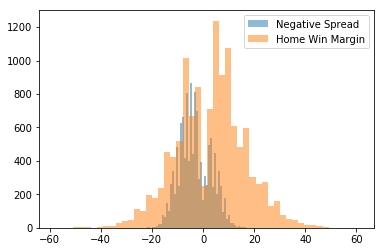

In [372]:

plt.hist(nba.spread, bins=50, alpha=0.5, label='Negative Spread')
plt.hist(nba.home_win_margin, bins=50, alpha=0.5, label='Home Win Margin')
plt.legend(loc='upper right')
plt.show()

### High Altitiude Dummy

There are two Western Conference Teams that play at high altitude.  These games are tougher for some away teams especially coming off of a long road trip.  We create a dummy to account for the travel.  

In [373]:
nba['high_alt'] = nba.teams.map(lambda x: 1 if (x == "Denver") or 
                                (x== "Utah") else 0)

nba_test['high_alt'] = nba.teams.map(lambda x: 1 if (x == "Denver") or 
                                (x== "Utah") else 0)

### Changing Rest Features to Dummies

The NBA schedule is not fixed and many teams have a different amount or rest entering games.  Last season they changed some rules and started the season earlier to make the season less taxing, but it is still important to account for the various

We will create a variable for each.  This will greatly expand our number of features as will future dummying that is, but the plan is to do feature extraction using Principal Components analysis so the feature increase should not be too onerous on the model.


In [374]:
nba = pd.get_dummies(nba , columns= ['away_rest', 'rest_days'], drop_first= True)
nba_test = pd.get_dummies(nba_test , columns= ['away_rest', 'rest_days'], drop_first= True)

### Teams Dummies

It is also important to distinguish between teams teams venues and support might influence the outcomes of games.  Here we dummy teams accomplish that goal.



In [375]:
#nba = nba = pd.get_dummies(nba, columns = ['teams', 'away_team'], drop_first = True)

### Referee Dummies 

The final dummy conversions are for the referee information.  Three referees generally work an NBA game.  We have the values for each and will convert them to dummies to incorporate any referee tendencies.

In [376]:
#nba = pd.get_dummies(nba, columns = ['ref_1','crew_referees','ref_3'], drop_first = True)

### Cumulative Stats Variables

There are for cumulative stats variable we generated Average win margin and Average win percentage for both home and away variables

In [377]:
#nba.dropna(inplace = True)

In [378]:
#graph.plothist('home_ave_win_margin')

In [379]:
nba.home_ave_win_margin.value_counts()

 0.500000    48
 0.000000    46
 1.500000    45
 1.000000    45
 2.000000    43
-0.500000    39
-1.500000    35
 0.750000    33
 1.250000    32
-2.000000    29
 2.500000    27
-1.000000    27
-3.000000    24
-2.500000    23
 0.833333    23
 1.750000    23
 0.333333    23
 3.000000    23
-0.250000    23
 2.250000    22
-0.750000    22
 4.500000    21
 1.333333    21
-4.000000    20
 4.000000    19
 2.333333    18
-0.857143    18
-3.500000    17
 5.500000    17
 0.600000    17
             ..
-1.243243     1
 2.759259     1
-7.833333     1
 3.486486     1
-8.423077     1
 1.827586     1
-4.388889     1
-2.986486     1
-2.275000     1
-7.708333     1
 3.777778     1
-2.102564     1
 1.445652     1
-4.636364     1
 7.062500     1
-1.109756     1
 5.892857     1
-6.812500     1
-4.861111     1
-7.687500     1
-4.196429     1
 0.392857     1
 3.468750     1
 0.271739     1
-2.160714     1
-9.125000     1
 3.906250     1
-1.765625     1
 0.621622     1
 1.015152     1
Name: home_ave_win_margi

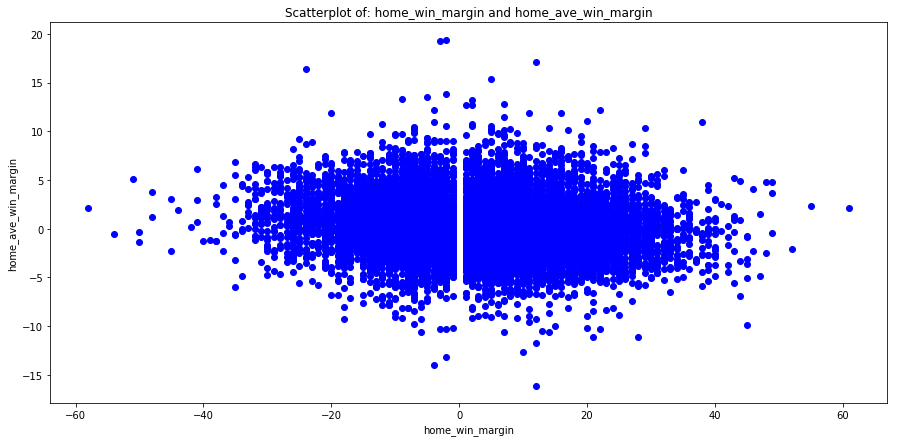

In [380]:
graph.plotscat('home_win_margin', 'home_ave_win_margin')

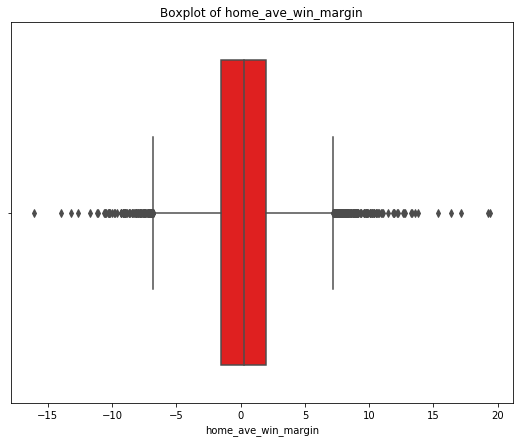

In [381]:
graph.plotbox('home_ave_win_margin')

In [382]:
nba.home_win_margin.corr(nba.home_ave_win_margin)
#strong positive correlation

-0.1235210959795386

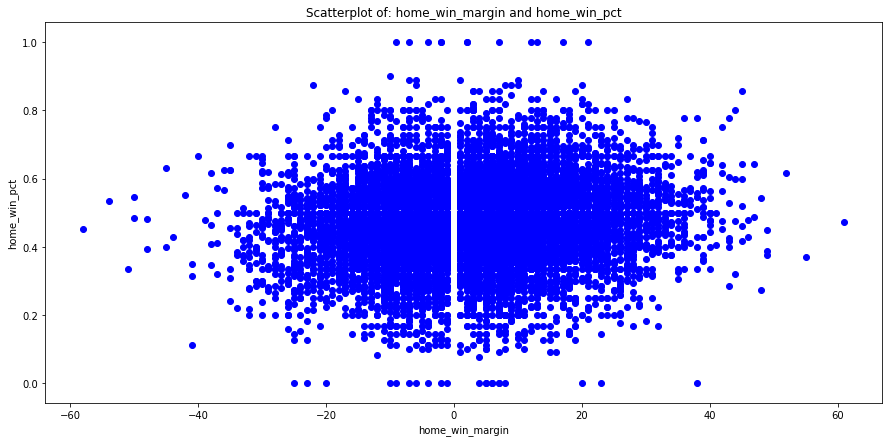

In [383]:
graph.plotscat('home_win_margin', 'home_win_pct')

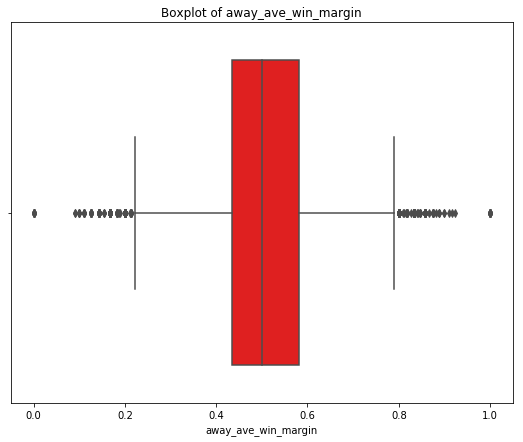

In [384]:
graph.plotbox('away_ave_win_margin')

In [385]:
nba.home_win_margin.corr(nba.home_win_pct)
#strong positive correlation

0.11165659835319179

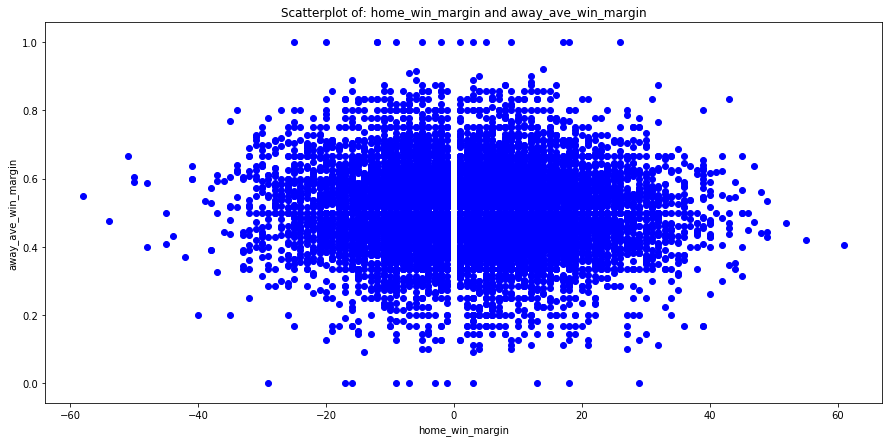

In [386]:
graph.plotscat('home_win_margin', 'away_ave_win_margin')

In [387]:
nba.home_win_margin.corr(nba.away_ave_win_margin)


-0.06387326689987272

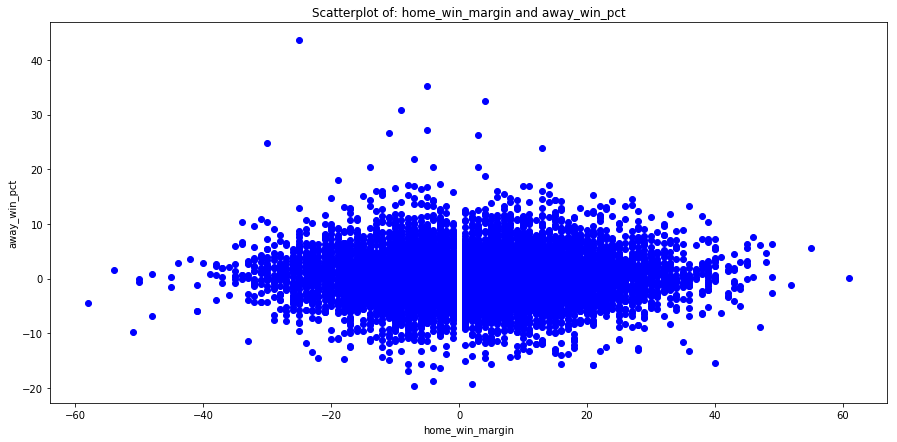

In [388]:
graph.plotscat('home_win_margin', 'away_win_pct')

In [389]:
nba.home_win_margin.corr(nba.away_win_pct)


0.018724349897020806

### Relative Offensive and Defensive efficiencies

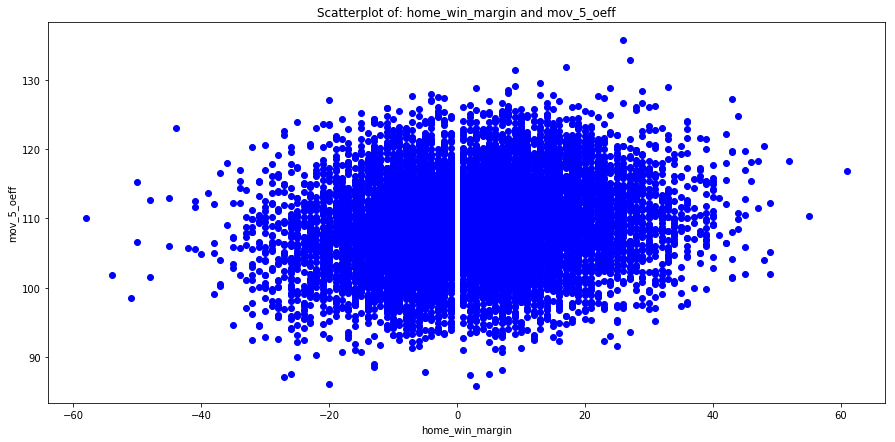

In [390]:

graph.plotscat('home_win_margin', 'mov_5_oeff')



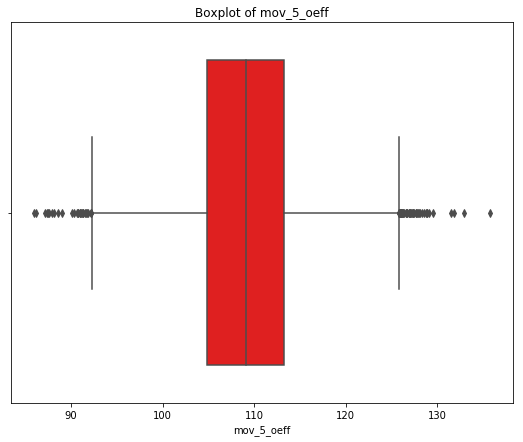

In [391]:
graph.plotbox('mov_5_oeff')

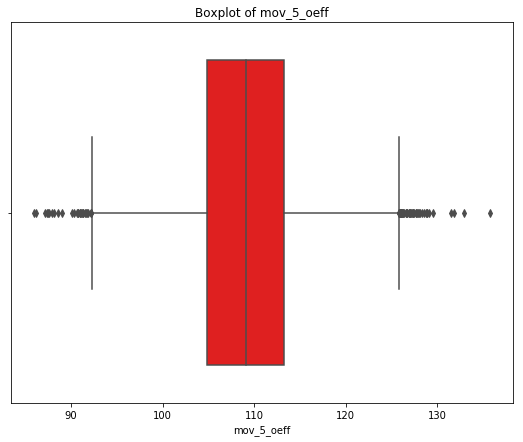

In [392]:
graph.plotbox('mov_5_oeff')

In [393]:
nba.home_win_margin.corr(nba.mov_5_oeff)

0.16817928245073488

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Offensive Efficeincy Numbers')

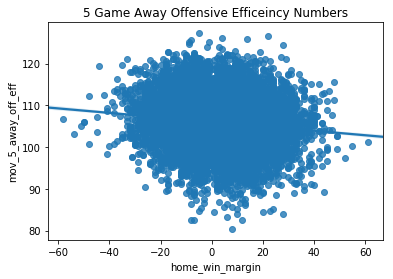

In [394]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_off_eff)
plt.title("5 Game Away Offensive Efficeincy Numbers")

In [395]:
nba.home_win_margin.corr(nba.mov_5_away_off_eff)

-0.12155448590962288

In [396]:
#eff ratio ratio by line for 3 and 5 game moving averages
nba['eff_ratio1'] = ((nba.mov_5_deff )/(nba.mov_5_away_def_eff ))  
nba['eff_ratio2'] = (nba.mov_5_oeff/ nba.mov_5_away_off_eff) 
nba['eff_ratio3'] = ((nba.last_deff )/(nba.lastaway_def_eff ))  
nba['eff_ratio4'] = (nba.last_oeff/ nba.lastaway_off_eff)  

In [397]:
#eff ratio ratio by line for 3 and 5 game moving averages
nba_test['eff_ratio1'] = ((nba_test.mov_5_deff 
                          )/(nba_test.mov_5_away_def_eff ))  
nba_test['eff_ratio2'] = ((nba_test.mov_5_oeff
                          )/ nba.mov_5_away_off_eff) 
nba_test['eff_ratio3'] = ((nba_test.last_deff 
                          )/(nba_test.lastaway_def_eff ))  
nba_test['eff_ratio4'] = ((nba_test.last_oeff
                          )/ nba_test.lastaway_off_eff) 

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Offensive efficiency ratio')

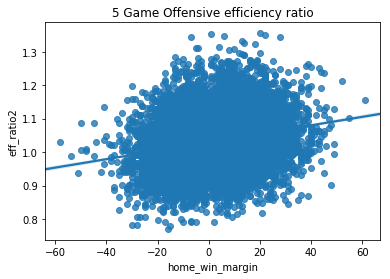

In [398]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.eff_ratio2)
plt.title("5 Game Offensive efficiency ratio")

In [399]:
nba.home_win_margin.corr(nba.eff_ratio1)

-0.18863931295258476

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Win Margin Moving Average')

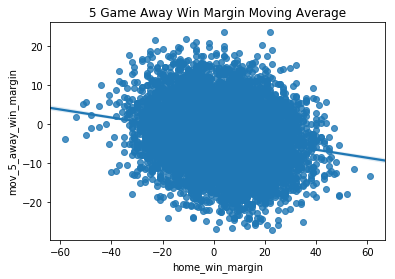

In [400]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_win_margin)
plt.title("5 Game Away Win Margin Moving Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Win Margin Moving Average')

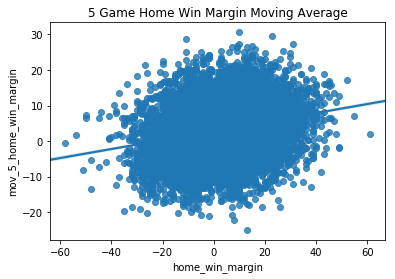

In [401]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_home_win_margin)
plt.title("5 Game Home Win Margin Moving Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Win Margin Moving Average')

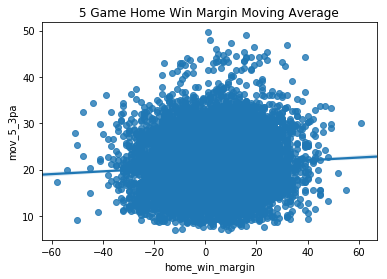

In [402]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_3pa)
plt.title("5 Game Home Win Margin Moving Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away 3 Point Attempts')

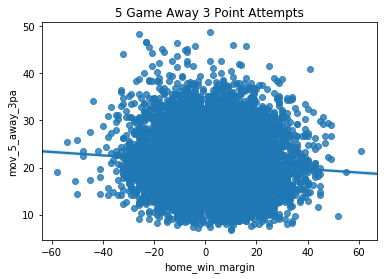

In [403]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_3pa)
plt.title("5 Game Away 3 Point Attempts")

In [404]:
nba['home_score_margin'] = nba.mov_5_home_score*nba.home_ave_win_margin
nba['away_score_margin'] = nba.mov_5_away_score*nba.away_ave_win_margin

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Score * Cumulative Win Margin')

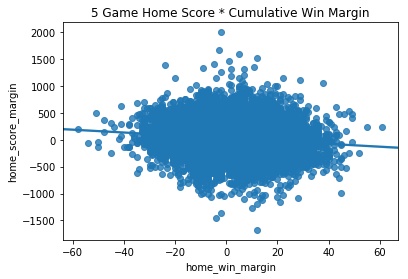

In [405]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.home_score_margin)
plt.title("5 Game Home Score * Cumulative Win Margin")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Score * Cumulative Away Win Margin')

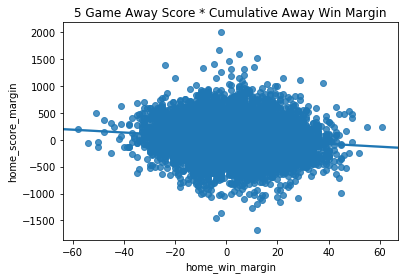

In [406]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.home_score_margin)
plt.title("5 Game Away Score * Cumulative Away Win Margin")

###  Traveling to High Altitude Locations

Traveling to high altitude locations can be tiring for players not used to altitude.  Check to see if these location make a difference.

#### Assists

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Assist Average')

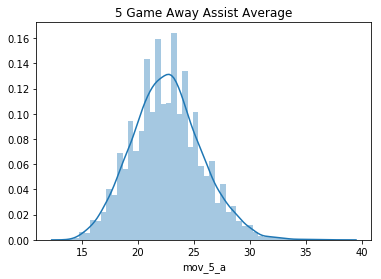

In [407]:
plt.gcf()
sns.distplot(nba.mov_5_a)
plt.title("5 Game Away Assist Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Assist Average')

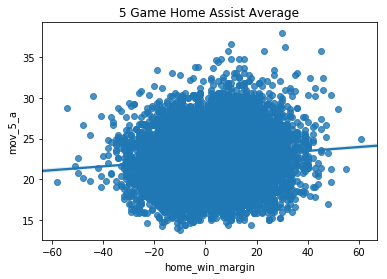

In [408]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_a)
plt.title("5 Game Home Assist Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Assist Average')

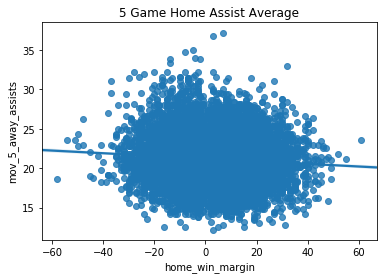

In [409]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_assists)
plt.title("5 Game Home Assist Average")

In [410]:
assist_ratio = nba.mov_5_a/nba.mov_5_away_assists

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Assist Average')

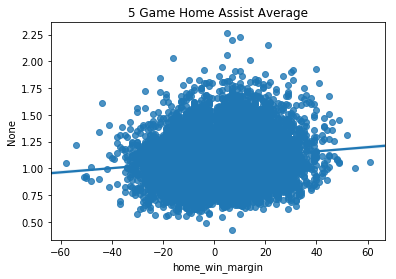

In [411]:
plt.gcf()
sns.regplot(nba.home_win_margin, assist_ratio)
plt.title("5 Game Home Assist Average")

#### Three Point Attempts

### Travel from West Coast/ East Coast

It is hypothesized that Traveling from West Coast to East Coast is more difficult as losing time makes it tougher to acclimate.  Check to see if this is a factor

In [412]:

### Travel Distance

In [413]:
nba.dataset.value_counts()

2007-2008 Regular Season    1061
2006-2007 Regular Season    1058
2008-2009 Regular Season     983
2009-2010 Regular Season     982
2010-2011 Regular Season     980
2014-2015 Regular Season     914
2013-2014 Regular Season     914
2017-2018 Regular Season     912
2015-2016 Regular Season     912
2016-2017 Regular Season     907
2012-2013 Regular Season     903
2011-2012 Regular Season     758
2009 Playoffs                 85
2008 Playoffs                 83
2007 Playoffs                 78
2010 Playoffs                 76
2018 Playoffs                 76
2015 Playoffs                 75
2017 Playoffs                 74
2013 Playoffs                 67
2016 Playoffs                 65
2011 Playoffs                 63
2012 Playoffs                 61
2014 Playoffs                 58
Name: dataset, dtype: int64

### Playoff Games

Currently, the data sets contain both regular season and playoff games.  Here I create a feature dummy variable that indicates the game is a playoff game.

In [414]:
nba['playoff_game'] = nba.dataset.map(lambda x:1 if x[5] =='P' else 0)

In [415]:
nba.playoff_game.value_counts()

0    11284
1      861
Name: playoff_game, dtype: int64

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'playoff games')

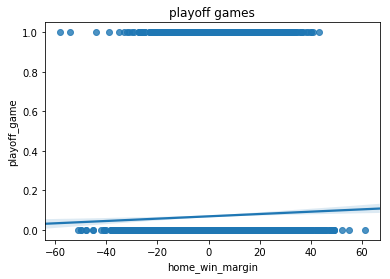

In [416]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.playoff_game)
plt.title("playoff games")

### Conference games

In [417]:
nba.teams.value_counts()

Cleveland       465
San_Antonio     460
Miami           451
Golden_State    451
Boston          446
Houston         439
Atlanta         434
Indiana         430
Washington      428
Chicago         428
LA_Lakers       427
Utah            426
Detroit         425
Orlando         425
Toronto         424
Memphis         418
Milwaukee       418
LA_Clippers     416
Denver          415
Dallas          415
Portland        413
Philadelphia    412
New_York        410
New_Orleans     410
Phoenix         409
Minnesota       397
Sacramento      389
Charlotte       388
New_Jersey      205
Seattle          71
Name: teams, dtype: int64

In [418]:

eastern =  ['Atlanta', 'Boston', 'Charlotte', 'Cleveland', 'Detroit',
            'Miami', 'Indiana', 'Washington', 'Chicago', 'Orlando', 
            'Toronto', 'Milwaukee', 'Philadelphia', 'New_York', 
            'New_Jersey']

nba['home_conference'] = nba.teams.map(lambda x:
                                       1 if x in eastern else 0)
nba['away_conference'] = nba.away_team.map(lambda x:
                                       1 if x in eastern else 0)
nba['in_conference_game'] = nba['home_conference'] * nba['away_conference']     

In [419]:
nba.home_conference.value_counts()

1    6189
0    5956
Name: home_conference, dtype: int64

### Problem with Traditional Metrics

Our first models concentrated on traditional metrics such as scoring and effeciency numbers did not have any explanatory power in predicting the spread.  Some of this is due to the fact that the spread is created using these numbers so they do not predict better than the spread.  So while I will keep some of these variable in the model. I want to look for subsets of the data that the model might not predict as well.  The first subset that I chose was playoff games.  The spread does not predict playoff games nearly as well as regular season. The difference between the average win margin and the spread is .7 almost twice as high as the normal line.  In addition the advantage is for home teams and the home team covers over 52% of the time.  

This make theoretical sense as betting public generally likes to bet the favorites. They think that a better team will win on the road even if that is not born out by statistics.  I will take this subset of data and see if I can predict this better than the spread.   

In [420]:
print(nba[nba.playoff_game == 1].home_win_margin.mean())
print(nba[nba.playoff_game == 1].cover.mean())
np.std(nba[nba.playoff_game ==1].home_win_margin)

4.502903600464576
0.521486643437863


14.021687314526012

In [421]:
print(nba[nba.playoff_game == 1].spread.mean())
np.std(nba[nba.playoff_game == 1].spread)

-3.8397212543554007


4.887215958946939

#### Small Away team dogs coming off a outright win






In [422]:
nba.to_csv('./data/nba_analysis_data.csv', index = False)


In [423]:
print(nba.cover.mean())
print(nba[nba.playoff_game == 1].cover.mean())
np.std(nba[nba.playoff_game ==1].home_win_margin)

0.4804446274186908
0.521486643437863


14.021687314526012

In [424]:
print(nba.total.median())
print(np.std(nba.total))

200.5
11.583861920218494


In [425]:
print(nba.total_diff.median())
np.std(nba.total_diff)

0.0


17.623321281939045

In [426]:
print(nba['total_score'].median ())
np.std(nba.total_score)

200.0


20.782930957150413